# CIFAR Conv Net

И так, в этом ноутбуке Вы сделаете превую в своей жизни сверточную сеть! На сложном датасете. Cкачайте его кстати, 

In [1]:
!mkdir cifar10
!wget cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvzf cifar-10-python.tar.gz -C cifar10

--2017-04-25 12:21:24--  http://cifar-10-python.tar.gz/
Распознаётся cifar-10-python.tar.gz (cifar-10-python.tar.gz)… ошибка: Имя или служба не известны.
wget: не удаётся разрешить адрес «cifar-10-python.tar.gz»
--2017-04-25 12:21:24--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Распознаётся www.cs.toronto.edu (www.cs.toronto.edu)… 128.100.3.30
Подключение к www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 170498071 (163M) [application/x-gzip]
Сохранение в: «cifar-10-python.tar.gz»

cifar-10-python.tar 100%[===================>] 162,60M  6,54MB/s    in 22s     

2017-04-25 12:21:47 (7,30 MB/s) - «cifar-10-python.tar.gz» сохранён [170498071/170498071]

ЗАВЕРШЕНО --2017-04-25 12:21:47--
Общее время: 23s
Загружено: 1 файлов, 163M за 22s (7,30 MB/s)
cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.vq import whiten
from scipy.stats import bernoulli

%matplotlib inline

In [2]:
def reflect(X):
    reflected = np.zeros_like(X)
    n, m, k = X.shape
    for i in range(n):
        for j in range(m):
            for t in range(k):
                reflected[i][j][k - t - 1] = X[i][j][t]
    return reflected

In [6]:
from cifar import load_CIFAR10
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

cifar10_dir = './cifar10/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
X_train /= 255.0
X_test /= 255.0

X_train, X_test = whiten(X_train), whiten(X_test)

X_val, y_val = X_test, y_test

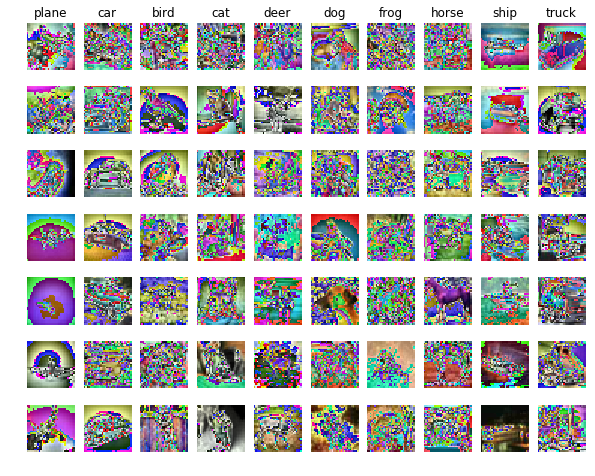

In [7]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('float32').transpose(1, 2, 0))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Чем отличаются современные сверточные сети от сетей 5 летней давности?

<Ответ>

**Вопрос 2**: Какие неприятности могут возникнуть во время обучения современных нейросетей?

<Ответ>


**Вопрос 3**: У вас есть очень маленький датасет из 100 картинок, классификация, но вы очень хотите использовать нейросеть, какие неприятности вас ждут и как их решить? что делать если первый вариант  решения не заработает?

<Ответ>

**Вопрос 4**: Как сделать стайл трансфер для музыки? oO

<Ответ>

In [8]:
import lasagne
from theano import tensor as T
from lasagne.nonlinearities import *

input_X = T.tensor4("X")
target_y = T.vector("target Y integer",dtype='int32')

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/usr/local/lib/python2.7/site-packages/Theano-0.8.2-py2.7.egg/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


### Соберите нейронку: 
- Many times x (Conv+Pool)
- Many small convolutions like 3x3
- Batch Norm 
- Residual Connection
- Data Augmentation 
- Learning rate Schedule 
- ...

### Для вдохновения 
- http://torch.ch/blog/2015/07/30/cifar.html
- https://github.com/szagoruyko/wide-residual-networks 

### Самое интересное
- Для сдачи задания нужно набрать на точность тесте > **92.5**% (это займет много времени, торопитесь :) )
- Для получения бонусных баллов > **95.0**%
- Будет очень хорошо если вы придумаете свою архитектуру или сможете обучить что-то из вышеперечисленного :)
- А для обучения всего этого добра вам будет куда удобнее использовать GPU на Amazon 
    - Инструкция https://github.com/persiyanov/ml-mipt/tree/master/amazon-howto 
    - Вам помогут tmux, CuDNN, ssh tunnel, nvidia-smi, ... 
    - Have fun :)

In [9]:
from lasagne.layers import batch_norm, InputLayer, GaussianNoiseLayer, FlattenLayer, \
                        NonlinearityLayer, Conv2DLayer, \
                        Pool2DLayer, DenseLayer, \
                        ElemwiseSumLayer, DropoutLayer

In [10]:
def residual_block(layer, num_filters, filter_size=3, stride=1, num_layers=2):
    conv = layer
    if (num_filters != layer.output_shape[1]) or (stride != 1):
        layer = Conv2DLayer(layer, num_filters, filter_size=1, stride=stride, pad=0, nonlinearity=None, b=None)
    for _ in range(num_layers):
        conv = Conv2DLayer(conv, num_filters, filter_size, stride=stride, pad='same')
        stride = 1
    return ElemwiseSumLayer([conv, layer])

In [54]:
##BEST ~85.5%

net=InputLayer(shape=(None,3, 32, 32), input_var=input_X)



net=Conv2DLayer(net,num_filters=32,filter_size=3,pad=1,nonlinearity=None)
net=batch_norm(net)
net=NonlinearityLayer(net)
net=Conv2DLayer(net,num_filters=32,filter_size=3,pad=1,nonlinearity=rectify)
net=Conv2DLayer(net,num_filters=32,filter_size=3,pad=1,nonlinearity=rectify)
net=Pool2DLayer(net,pool_size=2)

net=residual_block(net, 64)
net=batch_norm(net)
net=Pool2DLayer(net,pool_size=2)

net=residual_block(net, 128, num_layers=3)
net=Pool2DLayer(net,pool_size=2)

net=residual_block(net, 256, num_layers=3)
net=batch_norm(net)
net=NonlinearityLayer(net)

net=residual_block(net, 256, num_layers=3)
net=batch_norm(net)
net=NonlinearityLayer(net)

net=Pool2DLayer(net,pool_size=2)

net=DenseLayer(net,num_units=4096, nonlinearity=None)
net=batch_norm(net)
net=NonlinearityLayer(net)
net=DenseLayer(net,num_units=4096)
net=DropoutLayer(net, p=0.5)

net=DenseLayer(net,num_units = 10, nonlinearity=softmax)

In [55]:
y_predicted = lasagne.layers.get_output(net)
all_weights = lasagne.layers.get_all_params(net, trainable=True)
print all_weights

[W, beta, gamma, W, b, W, b, W, b, W, b, W, beta, gamma, W, b, W, b, W, b, W, W, b, W, b, W, b, W, beta, gamma, W, b, W, b, W, b, beta, gamma, W, beta, gamma, W, b, W, b]


In [56]:
loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()
eta = theano.shared(lasagne.utils.floatX(1e-3))
updates = lasagne.updates.adam(loss, all_weights, learning_rate=eta)
#updates = lasagne.updates.adadelta(loss, all_weights,learning_rate=0.01)
#updates = lasagne.updates.momentum(loss, all_weights, learning_rate=0.1, momentum=0.7)

In [57]:
train_fun = theano.function([input_X,target_y],[loss, accuracy], updates=updates, allow_input_downcast=True)
accuracy_fun = theano.function([input_X,target_y],accuracy, allow_input_downcast=True)

### Вот и всё, пошли её учить

In [39]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        
        flips = bernoulli.rvs(p=0.5, size=batch_size)
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
            
        to_yield = inputs[excerpt]
        to_yield[flips] = np.flip(to_yield[flips], 3)
        
        yield to_yield, targets[excerpt]

# Процесс обучения

In [60]:
import time

num_epochs = 200 #количество проходов по данным

batch_size = 150 #размер мини-батча

for epoch in range(29, num_epochs):
    
    if (epoch > 0 and epoch % 10 == 0):
        eta.set_value(lasagne.utils.floatX(eta.get_value() / 10))
    
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))

Epoch 30 of 200 took 95.490s
  training loss (in-iteration):		0.002547
  train accuracy:		99.97 %
  validation accuracy:		81.57 %
Epoch 31 of 200 took 95.322s
  training loss (in-iteration):		0.002339
  train accuracy:		99.97 %
  validation accuracy:		81.22 %


KeyboardInterrupt: 

In [59]:
epoch

29

In [61]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 92.5:
    print "Achievement unlocked: колдун 80 уровня"
else:
    print "Нужно больше магии!"

Final results:
  test accuracy:		81.61 %
Нужно больше магии!


## Заполните форму

https://goo.gl/forms/EeadABISlVmdJqgr2 